In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
df=pd.read_csv("WMT.csv")
print(df.head())
df.info()

         Date      Open      High       Low     Close  Adj Close   Volume
0  1972-08-25  0.063477  0.064697  0.063477  0.064453   0.036447  2508800
1  1972-08-28  0.064453  0.064941  0.064209  0.064209   0.036309   972800
2  1972-08-29  0.063965  0.063965  0.063477  0.063477   0.035895  1945600
3  1972-08-30  0.063477  0.063477  0.062988  0.063477   0.035895   409600
4  1972-08-31  0.062988  0.062988  0.062500  0.062500   0.035343   870400
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12491 entries, 0 to 12490
Data columns (total 7 columns):
Date         12491 non-null object
Open         12491 non-null float64
High         12491 non-null float64
Low          12491 non-null float64
Close        12491 non-null float64
Adj Close    12491 non-null float64
Volume       12491 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 683.2+ KB


In [3]:
closed_prices=df["Close"]
seq_len=15
mm=MinMaxScaler()
scaled_price=mm.fit_transform(np.array(closed_prices)[...,None]).squeeze()
print(scaled_price)

[3.19608588e-04 3.18011461e-04 3.13220082e-04 ... 9.34740453e-01
 9.27212954e-01 9.27212954e-01]


In [4]:
x=[]
y=[]
for i in range(len(scaled_price)-seq_len):
    x.append(scaled_price[i:i+seq_len])
    y.append(scaled_price[i+seq_len])

In [5]:
x=np.array(x)[...,None]
y=np.array(y)[...,None]

train_x = torch.from_numpy(x[:int(0.8 * x.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * y.shape[0])]).float().unsqueeze(1)
test_x = torch.from_numpy(x[int(0.8 * x.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * y.shape[0]):]).float().unsqueeze(1)
print(train_x.shape,test_x.shape)
print(train_y.shape,test_y.shape)

torch.Size([9980, 15, 1]) torch.Size([2496, 15, 1])
torch.Size([9980, 1, 1]) torch.Size([2496, 1, 1])


10 epoch loss 0.02396327815949917
20 epoch loss 0.016976986080408096
30 epoch loss 0.011257613077759743
40 epoch loss 0.0008512182394042611
50 epoch loss 0.0008760219207033515
60 epoch loss 0.0005795490578748286
70 epoch loss 0.00025307817850261927
80 epoch loss 0.00020398157357703894
90 epoch loss 0.00018633753643371165
100 epoch loss 0.00016029107791837305


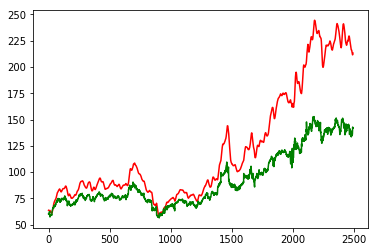

In [6]:
class Model(nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.lstm=nn.LSTM(input_size,hidden_size,batch_first=True)
        self.fc=nn.Linear(hidden_size,1)
    def forward(self,x):
        output,(hidden,cell)=self.lstm(x)
        return self.fc(hidden[-1,:])
model=Model(1,150)

optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn=nn.MSELoss()
num_epochs=110
for epoch in range(num_epochs):
    output=model(train_x)
    loss=loss_fn(output,train_y.squeeze(1))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%10==0 and epoch!=0:
        print(epoch,"epoch loss",loss.item())
        
model.eval()
with torch.no_grad():
    output=model(test_x)
    
    
pred=mm.inverse_transform(output.numpy())
test_y_2d=test_y.reshape(-1,1)
real=mm.inverse_transform(test_y_2d.numpy())

plt.plot(pred.squeeze(),color="red",label="predicted")
plt.plot(real.squeeze(),color="green",label="real")
plt.show()